In [1]:
# # adapting simon's older PC-based 1dvar code to read in GMI 
# data and run oceanic retrievals. started DD 17/05/18
#   - - working as wv retrieval 03/06/18
#  playing with surface retrieval (jacobians first), DD late august 2018

# revisited DD mid Dec 2018 for running 1dvar sfc retrieval

# Set up ARTS/Python environment


In [2]:
%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/

%matplotlib inline
import glob
from h5py import File

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/


/home/dudavid/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [3]:
#import typhon
#typhon.__version__

In [4]:
from typhon.arts.workspace.variables import *

ws.Copy( ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

In [5]:
# define absorbing species and sensor (here using metmm library, used again below)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])
ws.abs_lines_per_speciesSetEmpty()

# General Settings

In [6]:
ws.stokes_dim = 2 # to get V and H pol out of metmm
ws.iy_unit = "PlanckBT" # equivalent: ws.StringSet( iy_unit, "PlanckBT" )

# Atmosphere set up # (take Psfc, T from model later)

In [7]:
ws.atmosphere_dim = 1  # for 1DVAR
p = np.array([1013.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = p[:] #0.5 * (p[1:] + p[:-1])
print(ws.p_grid.value)
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmosphereSet1D()
ws.AtmFieldsCalc()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]


[101300.  97500.  95000.  92500.  90000.  85000.  80000.  75000.  70000.
  65000.  60000.  55000.  50000.  40000.  30000.  20000.  10000.]


# Sensor definition -- GMI sensor setup w/ metmm

In [8]:
ws.ArrayOfIndexCreate("channels")
# initial sensor setup, all 13 channels at low frequency EIA
#csub = [[x for x in range(9)], [x+9 for x in range(4)]] # 13 GMI channels total
csub = [[0,1,2,3,6],[]]
#csub = [ [3,4,5,6], [11,12] ]#  define channel indices (0-8 10-89GHz, 9-12 166-183GHz)
nch = np.size(np.ravel(csub[0]+csub[1]))
print('# channels using: ',nch)
#ws.channels = csub #[0,:]+csub[1,:] #list(np.ravel(csub)) # 23.8 and 183 channels only for WV

ws.ArrayOfIndexCreate("viewing_angles") # necessary if just using one pencil beam angle?
#ws.viewing_angles = [1] # index of viewing angles in metmm file -- for GMI, 49.2, 52.8
# current setup is low freqs at index 1, high freqs at index 0

ws.sensor_pos  = np.array([[407e3]])#, -30.0, 180.0]]) # 407km alt, 30S, 180E
#can take exact alt from file if desired, same with lat/lon values (does that have effect?)
ws.sensor_time = np.array([0.0]) # same here
ws.sensor_los  = np.array([[180.0]]) # since angle taken care of in metmm file 
# zenith angle followed by azimuth. zenith=0 is straight up, 180 is straight down. azimuth=0 is N, positive to east 

ws.IndexCreate("met_mm_accuracy") 
ws.met_mm_accuracy = 1 # points within each bandwidth to comute abs characteristics


# channels using:  5


# Perform some checks

In [9]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
#ws.abs_lookupSetup() # not currently using lookup tables (on the fly instead)
#ws.abs_lookupCalc()

# define surface agendas -- unnecessary right now

In [10]:
#from typhon.arts.workspace import arts_agenda
#
#@arts_agenda
#def surface_fastem(ws):
#    ws.specular_losCalc()
#    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
#    ws.surfaceFastem(wind_speed     = ws.wind_speed,
#                     wind_direction = ws.wind_direction,
#                     transmittance  = ws.transmittance)
#    
#    
#ws.TessemNNReadAscii(tessem_netv, "testdata/tessem_sav_net_V.txt")
#ws.TessemNNReadAscii(tessem_neth, "testdata/tessem_sav_net_H.txt") 
#@arts_agenda
#def surface_tessem(ws):
#    ws.specular_losCalc()
#    ws.InterpSurfaceFieldToPosition( out = ws.surface_skin_t, field = ws.t_surface )
#    ws.SurfaceTessem(wind_speed     = ws.wind_speed) # one with capital S and one without?!
#
## set surface agenda (i.e. either fastem or tessem) here:
##ws.Copy(ws.surface_rtprop_agenda, surface_fastem) # choose which emis. model to run here!
#ws.Copy(ws.surface_rtprop_agenda, surface_tessem) # choose which emis. model to run here!

# Designate surface vars

In [11]:

ws.NumericCreate("wind_speed")
ws.NumericCreate("wind_direction")
ws.wind_speed = 3.5
ws.surface_skin_t = 290.2
#ws.wind_direction = 0.0 # can adjust based on analysis data later  -- default should be 0
# -- need sensor azimuth angle, and spacecraft heading, as arts azimuth is relative to N
#ws.salinity = .035 # default is .035 anyway

# transmittance only needed for running fastem:
#ws.VectorCreate("transmittance")
#ws.transmittance  = np.ones(ws.f_grid.value.shape) # or ones, or something else?
print('wind speed, SST: ',ws.wind_speed.value,ws.surface_skin_t.value)#ws.t_surface.value.ravel()[0])

# add surface variables for jacobian calculation -- need to keep order consistent between snames/sdata
snames = ["Water skin temperature", "Wind speed", "Salinity"]
sdata = np.array([ws.surface_skin_t.value, ws.wind_speed.value, 0.035]).reshape(3,1,1)
#sdata = np.array([ws.t_surface.value.ravel()[0], ws.wind_speed.value, 0.035]).reshape(3,1,1)

# don't copy to arts variables yet... otherwise ycalc bombs due to SurfaceDummy [old issue]
ws.Copy(ws.surface_props_names, snames)
ws.Copy(ws.surface_props_data, sdata)


nrvar = 2 # num retrieved variables
rvars = np.zeros(nrvar)
#rvars[:] = [0.8, 2.2] # corresponding to variable order set above
rvars[:] = [4.2, 3.9] # corresponding to variable order set above

# set Xa (formally set below)
xa = np.zeros(nrvar) # if supplying user-defined a priori vector
xa[:] = [ws.surface_skin_t.value, ws.wind_speed.value] # just perturbations from values defined above
#xa[:] = [ws.surface_skin_t.value + .42, ws.wind_speed.value - 0.78] # just perturbations from values defined above

wind speed, SST:  3.5 290.2


In [12]:
#### want to get rid of SurfaceDummy from iy_surface agenda
#AgendaSet( iy_surface_agenda__UseSurfaceRtprop ){
#  SurfaceDummy
#  iySurfaceRtpropAgenda
#}

# read tessem ascii files into arts memory
ws.TessemNNReadAscii(tessem_netv, "testdata/tessem_sav_net_V.txt")
ws.TessemNNReadAscii(tessem_neth, "testdata/tessem_sav_net_H.txt") 
@arts_agenda
def iy_surface_agendaPY(ws):
    #ws.SurfaceFastem()  # doesn't work now
    ws.SurfaceTessem()
    ws.iySurfaceRtpropCalc()
    #ws.iySurfaceRtpropAgenda()
    # don't call SurfaceDummy()!
    
ws.Copy(ws.iy_surface_agenda, iy_surface_agendaPY) # copy python-defined agenda to ARTS

# define jacobians, run ycalc 

In [13]:

ws.ArrayOfIndexCreate("viewing_angles_1")
ws.viewing_angles_1 = [1] # index, defined in GMI metmm file
ws.ArrayOfIndexCreate("viewing_angles_2")
ws.viewing_angles_2 = [0]
ws.ArrayOfIndexCreate("channels_1") # low freq channels EIA
ws.channels_1 = csub[0]
ws.ArrayOfIndexCreate("channels_2") # high freq channels EIA
ws.channels_2 = csub[1] 
ws.Copy(ws.viewing_angles, ws.viewing_angles_1)
ws.Copy(ws.channels, ws.channels_1)

# re-execution of metmm control files ( since channels subset and angle have changed)
ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_gmi.arts") #atms.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts") # to execute CF?
#ws.VectorSetConstant(ws.transmittance, 1, 1.0) # needed for emis model, right size

# NO NEED TO RUN JACOBIAN INIT IF USING RETRIEVAL DEF INIT
#ws.jacobianInit()  # initialize jacobian quantities, then add variables
#ws.jacobianAddSurfaceQuantity(
#    g1=ws.lat_grid, g2=ws.lon_grid, quantity=snames[0])
#ws.jacobianAddSurfaceQuantity(
#    g1=ws.lat_grid, g2=ws.lon_grid, quantity=snames[1])
#ws.jacobianClose()
ws.retrievalDefInit()  # initialize jacobian quantities, then add variables

sx_cov = np.diag(rvars) # CHANGE TO MATCH SIZE OF Xa!!

ws.retrievalAddSurfaceQuantity(
    g1=ws.lat_grid, g2=ws.lon_grid, quantity=snames[0])
ws.covmat_sxAddBlock(block = sx_cov[:1, :1])

ws.retrievalAddSurfaceQuantity(
    g1=ws.lat_grid, g2=ws.lon_grid, quantity=snames[1])
ws.covmat_sxAddBlock(block = sx_cov[1:, 1:])

ws.Copy(ws.xa, xa)
# print Xa to terminal:
ws.Print(ws.xa,0) # Print Xa

chan_err = 1.6 # for now all the same, in K
se_cov = np.diag(np.zeros(nch) + chan_err**2 ) # set channel assumed errors
#print('Se diag ',np.diag(se_cov))
ws.covmat_seSet(se_cov)

ws.retrievalDefClose()

ws.cloudboxOff()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()

ws.yCalc()  # calculate yf and jacobian matching x
print(ws.y.value)
print(ws.jacobian.value)

# now run for other EIA, and append Tbs to previous EIA with yCalcAppend
if csub[1] != []: 
    ws.Copy(ws.viewing_angles, ws.viewing_angles_2)
    ws.Copy(ws.channels, ws.channels_2)
    
    ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
    ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_gmi.arts") #atms.arts")
    ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts") # to execute CF?
    #ws.VectorSetConstant(ws.transmittance,2,1.0) # needed for emis model, right size
    ws.yCalcAppend(jacobian_quantities_copy = ws.jacobian_quantities)
    print(ws.y.value)
    print(ws.jacobian.value)


[173.1945501   89.02697251 202.45884897 134.93689177 163.40777118]
[[ 0.43596595 -1.8290056 ]
 [-0.16537005  0.93008855]
 [ 0.37971272 -1.39527428]
 [-0.18507356  0.81346091]
 [-0.26295075  0.83464093]]


In [14]:
# setup for retrieval and sample jacobian seem right, time to run a sample retrieval:

@arts_agenda
def inversion_iterate_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter) # on simon's advice
    ws.x2artsAtmAndSurf()  # map x to ARTS's variables
    
    # NOTE: IF WANTING TO CHANGE CHANNELS/ANGLES, NEED TO USE arts COMMANDS ONLY!
    
    ws.Copy(ws.viewing_angles, ws.viewing_angles_1)
    ws.Copy(ws.channels, ws.channels_1)
    ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
    ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_gmi.arts") 
    ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts") 
    ws.yCalc() 

    if csub[1] != []: 
        # aka if any 166/183 channels exist in channel selection, run other angle
        ws.Copy(ws.viewing_angles, ws.viewing_angles_2)
        ws.Copy(ws.channels, ws.channels_2)
        ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
        ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_gmi.arts")
        ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
        ws.yCalcAppend(jacobian_quantities_copy = ws.jacobian_quantities)
        
    ws.Copy(ws.y_baseline,np.zeros(nch)) # kinda silly but necessary?
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term
    
    ws.jacobianAdjustAndTransform()
    # last line takes care of some fixes needed to get the jacobian right for iterative solutions

ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)

In [15]:
ws.inversion_iterate_agenda.print()

## Read in GMI TBs to use as observation vector

In [16]:
# Import GMI L1C file with brightness temperatures (TBs)
paf = '/home/dudavid/Dendrite/Dendrite/SatData/GMI/L1C/'
#l1c = glob.glob(paf+'*.HDF5')
#print(l1c[0])
#
#for f in l1c[0:1]:
#    gfi = File(f)
#    tb1 = gfi['S1/Tc'][:]   # given as [scans, pix], ie 2962x221
#    tb2 = gfi['S2/Tc'][:]
#    #print(np.shape(tbs),type(tbs))
#    tbs = np.append(tb1, tb2, axis=2) #gfi['S2/Tc'][:],axis=1)
#    print(np.shape(tbs))
    #lat = gfi['S1/Latitude'][:]
    #lon = gfi['S1/Longitude'][:]
    #eia = np.append(gfi['S1/incidenceAngle'][:],gfi['S2/incidenceAngle'][:],axis=2)
    #print(np.shape(eia)) # EIA is one for S1 channels, one for S2 (approx 52.8, 49.2 deg)
    # READ THESE IN BUT NOT CURRENTLY USED
    # can also import SC data, time data, etc from L1C file

gfi = File(paf+'1C-R.GPM.GMI.XCAL2016-C.20180418-S160617-E173849.023507.V05A.HDF5') # hand-picked orbit
tb1 = gfi['S1/Tc'][:]
tb2 = gfi['S2/Tc'][:]
tbs = np.append(tb1, tb2, axis=2) 
print(np.shape(tbs))
lat = gfi['S1/Latitude'][:]
lon = gfi['S1/Longitude'][:]
sel1 = np.logical_and(lon>-130, lon<-110)
sc,px = np.indices([lat.shape[0],lat.shape[1]])
sel2 = np.logical_and(lat[sel1]>0, lat[sel1]<20)
# scans where we're in about the right lat/lon range specified above:
scrange = np.round([np.mean(sc[sel1][sel2])-20, np.mean(sc[sel1][sel2])+20])
gmi_tbs = tbs[int(scrange[0]),90,:][:] # sure
gmi_tb = gmi_tbs[np.ravel(csub[0]+csub[1])]

# ...or use something modified by hand to be like the forward modeled one given the prior...
#gmi_tb = np.array([169.33739751 , 91.60115224 ,199.51783459 ,137.41204274 ,236.05000015,
# 220.68824268, 166.40211046, 271.53278258, 252.60123359, 283.12457811,
# 283.08760084, 258.52720733, 272.31574126])
print(gmi_tb)
#gmi_tb -= .71
#gmi_tb[0] += .4
#gmi_tb[2] += .7

ws.Copy(ws.y, gmi_tb)

(2962, 221, 13)
[171.98  95.8  205.76 146.44 173.33]


In [17]:
ws.OEM(method="lm", #lm","gn"
    max_iter=100,
    display_progress=1,
    max_start_cost=1e5,
    lm_ga_settings=np.array([10.0,2.0,3.0,10000000000.0,1.0,1.0]))
#ws.x2artsStandard() # convert from ARTS coords back to user-defined grid

ARTS[94643863324816]:     9        10.5494        6.99902        3.55036    4.86061e-20--------------------------------------------------------------------------------
ARTS[94643863324816]: 
ARTS[94643863324816]: Error during OEM computation.
ARTS[94643863324816]: 
ARTS[94643863324816]:                                       ----                                      
ARTS[94643863324816]: 



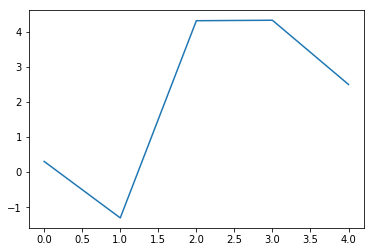

In [18]:
#ws.OEM?
plt.plot(ws.y.value - ws.yf.value)

In [19]:
ws.x.value


array([nan, nan])

In [20]:
ws.xa.value

array([290.2,   3.5])